In [1]:
include("OQS_Tools_v1.jl")
using LinearAlgebra, Plots, PolyChaos
using .OQS_Tools_v1

function evolve_corrs(C0, H, dt, tmax, N)
    n = 2N + 1
    Cs = Vector{Array{ComplexF64}}(undef, 0)
    times = collect(0:dt:tmax)
    C0 = Matrix(C0)
    H = Matrix(H)

    for t in times
        U = exp(-im * t * H)
        C = U * C0 * U'
        push!(Cs, C)
    end

    return Cs
end


evolve_corrs (generic function with 1 method)

In [16]:
N = 100
dt = 0.1
tmax = 100.0
Esys = 0.0
sys = N+1

D = 1.0
g = 0.1
beta = 1.0
mu = 0.0
sys_occ = 1.0

J = create_spectral("elliptical", D, g)
J1, J2 = thermofield_transform(J, beta, mu)

E1, h1 = chain_map(J1, N, D)
E2, h2 = chain_map(J2, N, D)
h = [reverse(h1); h2]

H = make_H_matrix(E1, E2, h1, h2, Esys, N, sys)
C0 = prepare_correlations(N,sys,sys_occ)
Cs = evolve_corrs(C0, H, dt, tmax, N)


1001-element Vector{Array{ComplexF64}}:
 [1.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im]
 [1.0000000000000004 + 2.5262869799515865e-31im -1.9712365169884845e-31 - 9.060741526030939e-18im … 0.0 + 0.0im 0.0 + 0.0im; -1.9712365169884845e-31 + 9.060741526030939e-18im 1.0000000000000004 - 3.0495045316643847e-31im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im]
 [1.0000000000000002 + 1.5803261289620685e-30im 3.4785706898070333e-31 - 3.684967567454919e-17im … 0.0 + 0.0im 0.0 + 0.0im; 3.4785706898070333e-31 + 3.684967567454919e-17im 1.0000000000000002 + 1.4251319942943553e-30im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im]
 [0.9999999999999997 + 2.9041158954955014e-3

# occupation

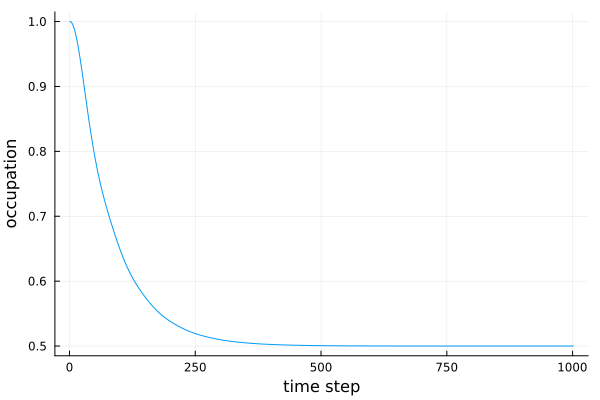

In [3]:
nsys = [real(C[sys,sys]) for C in Cs]
p = plot(nsys, xlabel="time step", ylabel="occupation",label="")
display(p)

# flux

In [4]:
anim = @animate for (t,C) in enumerate(Cs)
    flux = imag.(diag(C, 1)) .* 2 .* h
    occ = real.(diag(C, 0))
    p1 = plot(-N+0.5:1:N-0.5, flux, title="Time = $(round(dt*(t-1),digits=1))", 
        xlabel="inter-site",ylabel="flux", ylims=(0.0,0.3))
    p2 = plot(-N+0.5:1:N-0.5, flux, title="Time = $(round(dt*(t-1),digits=1))", 
        xlabel="inter-site",ylabel="flux", ylims=(0.0,0.3))
    end
gif(anim, "/Users/ben/AgeingManyBodyQuantumSys/figures/flux_g$(g)B$(beta)mu$(mu).mp4", fps=20)


┌ Info: Saved animation to /Users/ben/AgeingManyBodyQuantumSys/figures/flux_g0.1B1000.0mu0.0.mp4
└ @ Plots /Users/ben/.julia/packages/Plots/8ZnR3/src/animation.jl:156


Plots.AnimatedGif("/Users/ben/AgeingManyBodyQuantumSys/figures/flux_g0.1B1000.0mu0.0.mp4")

# Chain coefficients

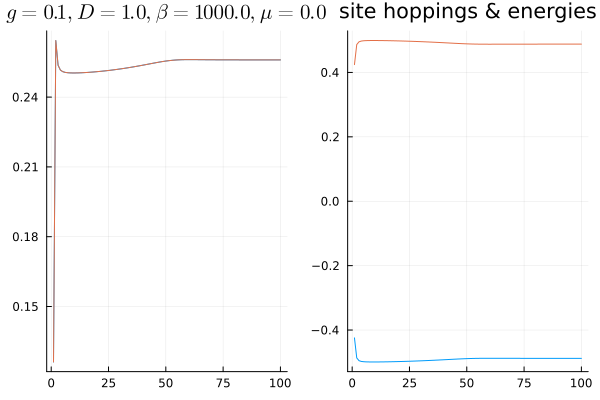

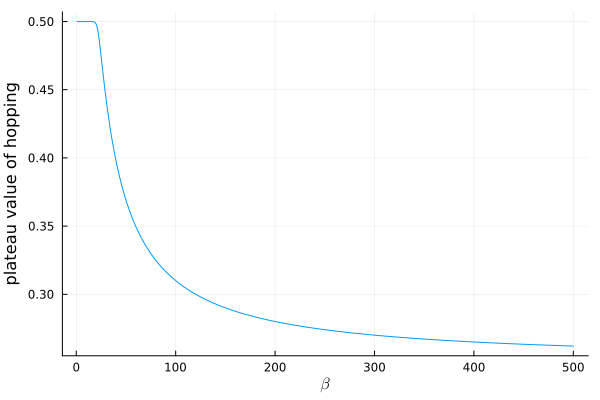

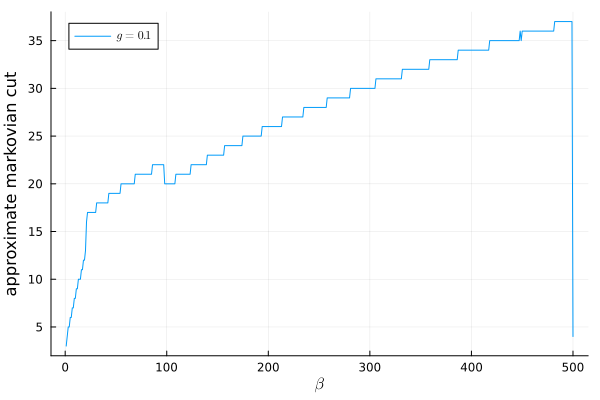

In [5]:
p1 = plot(h1, title="\$ g=$g, D=$D, \\beta=$beta, \\mu=$mu \$",label="")
plot!(p1, h2,label="")
p2 = plot(E1, title="site hoppings & energies",label="")
plot!(p2, E2,label="")
display(plot(p1,p2))

hf = zeros(500)
cutoff = zeros(500)
J = create_spectral("elliptical", D, g)
for (i, beta) in enumerate(1.0:1.0:500.0)
    Jt = thermofield_transform(J, beta, 0.0)[1]
    ht = chain_map(Jt, N, D)[2]
    hf[i] = ht[end]
    idx = findfirst(k -> maximum(ht[k:k+10]) - minimum(ht[k:k+10]) < 0.001 , collect(1:length(ht)-10))
    cutoff[i] = idx
end

display(plot(hf, xlabel="\$ \\beta \$", ylabel="plateau value of hopping",label=""))
display(plot(cutoff, xlabel="\$ \\beta \$", ylabel="approximate markovian cut",label="\$ g = $g \$"))




# measures

In [6]:
function trace_distance(A, B, n, N) #1st matrix, 2nd matrix, chain sites included, chain sites
    Ma = A[N+1-n:N+1+n,N+1-n:N+1+n]
    Mb = B[N+1-n:N+1+n,N+1-n:N+1+n]
    Id = I(2n+1)
    d2 = sqrt(0.5 * (det(Id - 2*Ma + 2*Ma*Ma) + det(Id - 2*Mb + 2*Mb*Mb) - 2*det(Id - Ma - Mb + 2*Ma*Mb)))
    return d2 #each term in D is the 'overlap' of the two correlation matrices
end

function block_entropy(C, n, N)
    Csub = C[N+1-n:N+1+n,N+1-n:N+1+n]
    Id = Matrix(1.0I, 2n+1, 2n+1)
    evals1 = eigvals(Csub)
    evals2 = eigvals(Id .- Csub)
    S = -sum(evals1 .* log.(evals1) .+ evals2 .* log.(evals2))
    return S
end

function VNentropy(C, n, N)
    Id = Matrix(1.0I, size(C))
    evals1 = eigvals(C)
    evals2 = eigvals(Id .- C)
    S = -sum(evals1 .* log.(evals1) .+ evals2 .* log.(evals2))
    return S
end

function mutual_info(C, n, N)
    Csub = C[N+1-n:N+1+n,N+1-n:N+1+n]
    Cfull = C[N+1-n:N+1, N+1-n:N+1]
    Cempty = C[N+1:N+1+n, N+1:N+1+n]
    return VNentropy(Cfull,n,N) + VNentropy(Cempty,n,N) - VNentropy(Csub,n,N)
end


mutual_info (generic function with 1 method)

In [7]:
C0_full = prepare_correlations(N,sys,1.0)
C0_empty = prepare_correlations(N,sys,0.0)

Cs_full = evolve_corrs(C0_full, H, dt, tmax, N)
Cs_empty = evolve_corrs(C0_empty, H, dt, tmax, N)
len = length(Cs_full)

anim = @animate for n in 0:50
    D = [trace_distance(Cs_full[t], Cs_empty[t], n, N) for t in 1:len]
    Df = D[2:end]
    Di = D[1:end-1]
    dD_dt = (Df - Di)/dt
    p1 = plot(real.(D),xlabel="timestep",ylabel="trace distance",title="n=$n")
    p2 = plot(real.(dD_dt),xlabel="timestep",ylabel="\$ \\frac{d}{dt}\$ trace distance",title="n=$n", yrange=(-0.3,0.1))
    p = plot(p1,p2)
end

gif(anim, "/Users/ben/AgeingManyBodyQuantumSys/figures/traceDist_g$(g)B$(beta)mu$(mu).mp4", fps=5)


┌ Info: Saved animation to /Users/ben/AgeingManyBodyQuantumSys/figures/traceDist_g0.1B1000.0mu0.0.mp4
└ @ Plots /Users/ben/.julia/packages/Plots/8ZnR3/src/animation.jl:156


Plots.AnimatedGif("/Users/ben/AgeingManyBodyQuantumSys/figures/traceDist_g0.1B1000.0mu0.0.mp4")

In [8]:
anim = @animate for n in 0:30
    S = [block_entropy(Cs_empty[t], n, N) for t in 1:len]
    S_f = S[2:end]
    S_i = S[1:end-1]
    sigma = (S_f - S_i)/dt
    println("n=$n")
    p = plot(real.(sigma),xlabel="timestep",ylabel="entropy production",title="n=$n",yrange=(-0.2,0.5))
end

gif(anim, "/Users/ben/AgeingManyBodyQuantumSys/figures/entropy_g$(g)B$(beta)mu$(mu).mp4", fps=1)


n=0
n=1
n=2
n=3
n=4
n=5
n=6
n=7
n=8
n=9
n=10
n=11
n=12
n=13
n=14
n=15
n=16
n=17
n=18
n=19
n=20
n=21
n=22
n=23
n=24
n=25
n=26
n=27
n=28
n=29
n=30


┌ Info: Saved animation to /Users/ben/AgeingManyBodyQuantumSys/figures/entropy_g0.1B1000.0mu0.0.mp4
└ @ Plots /Users/ben/.julia/packages/Plots/8ZnR3/src/animation.jl:156


Plots.AnimatedGif("/Users/ben/AgeingManyBodyQuantumSys/figures/entropy_g0.1B1000.0mu0.0.mp4")

In [17]:
anim = @animate for n in 0:30
    info = [mutual_info(Cs_empty[t], n, N) for t in 1:len]
    println("n=$n")
    p = plot(real.(info),xlabel="timestep",ylabel="mutual info between chains",title="n=$n")
end

gif(anim, "/Users/ben/AgeingManyBodyQuantumSys/figures/mutualInfo_g$(g)B$(beta)mu$(mu).mp4", fps=1)


n=0
n=1
n=2
n=3
n=4
n=5
n=6
n=7
n=8
n=9
n=10
n=11
n=12
n=13
n=14
n=15
n=16
n=17
n=18
n=19
n=20
n=21
n=22
n=23
n=24
n=25
n=26
n=27
n=28
n=29
n=30


┌ Info: Saved animation to /Users/ben/AgeingManyBodyQuantumSys/figures/mutualInfo_g0.1B1.0mu0.0.mp4
└ @ Plots /Users/ben/.julia/packages/Plots/8ZnR3/src/animation.jl:156


Plots.AnimatedGif("/Users/ben/AgeingManyBodyQuantumSys/figures/mutualInfo_g0.1B1.0mu0.0.mp4")

# BLP Measure

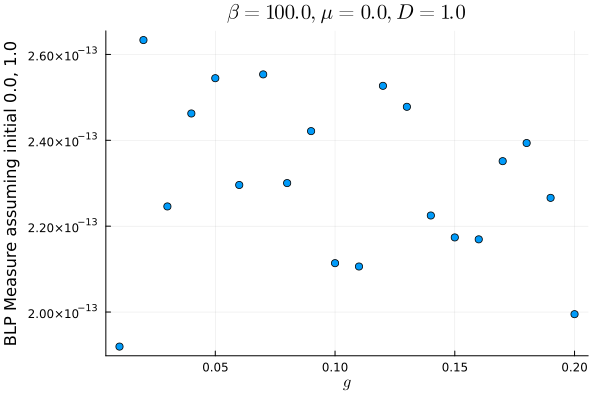

In [15]:
D = 1.0
beta = 100.0
mu = 0.0
N=100

gs = 0.01:0.01:0.2
BLP = []
for g in gs
    J = create_spectral("elliptical", D, g)
    J1, J2 = thermofield_transform(J, beta, mu)

    E1, h1 = chain_map(J1, N, D)
    E2, h2 = chain_map(J2, N, D)
    
    cut = findfirst(k -> maximum(h1[k:k+10]) - minimum(h1[k:k+10]) < 0.001 , collect(1:length(h1)-10))

    H = make_H_matrix(E1, E2, h1, h2, Esys, N, sys)
    C0_full = prepare_correlations(N,sys,1.0)
    C0_empty = prepare_correlations(N,sys,0.0)
    Cs_full = evolve_corrs(C0_full, H, dt, tmax, N)
    Cs_empty = evolve_corrs(C0_empty, H, dt, tmax, N)
    len = length(Cs_full)

    d2 = [trace_distance(Cs_full[t], Cs_empty[t], cut, N) for t in 1:len]
    Df = d2[2:end]
    Di = d2[1:end-1]
    dD_dt = real.(Df-Di)
    Nphi = sum(dD_dt[dD_dt .>= 0.0])
    push!(BLP, Nphi)
end

p = plot(gs, BLP, xlabel="\$ g \$", ylabel="BLP Measure assuming initial 0.0, 1.0",
    title="\$ \\beta=$(beta), \\mu=$(mu), D=$(D) \$",label="", seriestype=:scatter)

    




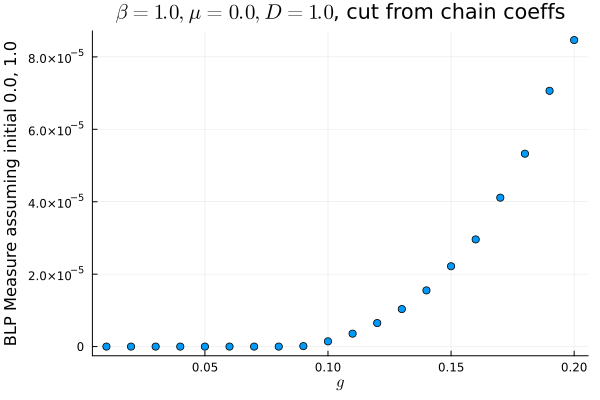

In [14]:
p = plot(gs, BLP, xlabel="\$ g \$", ylabel="BLP Measure assuming initial 0.0, 1.0",
    title="\$ \\beta=$(beta), \\mu=$(mu), D=$(D) \$, cut from chain coeffs",label="", seriestype=:scatter)
